<a href="https://colab.research.google.com/github/FuadKhalit/DeepLearningRepo/blob/main/Stock_Prediction_using_RNN_TATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prices Prediction Using Keras Long Short Term Memory

### Stock Prediction - Tata Global Beverages Ltd

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
# Importing the training set
data = pd.read_csv('/content/drive/MyDrive/Deep Learning/RNN_Timeseries/Train_Dataset.csv')
# "Open" has been taken as the target variable


In [6]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [7]:
# Read all rows and col 1 into dataframe ds
ds = data.iloc[:, 1:2]

In [8]:
ds.shape

(2035, 1)

In [9]:
ds.head

<bound method NDFrame.head of         Open
0     234.05
1     234.55
2     240.00
3     233.30
4     233.55
...      ...
2030  117.60
2031  120.10
2032  121.80
2033  120.30
2034  122.10

[2035 rows x 1 columns]>

In [10]:
# Read col1 into a numpy array
training_set = data.iloc[:, 1:2].values

training_set is a numpy array whereas ds is a dataframe

In [11]:
training_set.shape

(2035, 1)

In [12]:
print(training_set)

[[234.05]
 [234.55]
 [240.  ]
 ...
 [121.8 ]
 [120.3 ]
 [122.1 ]]


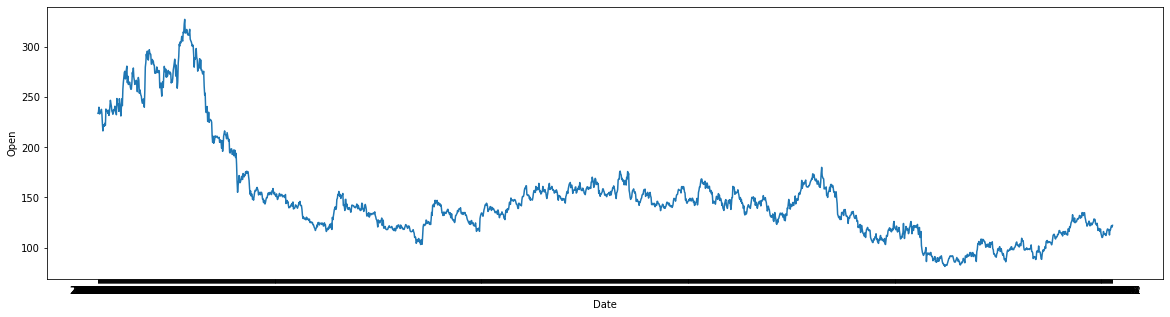

In [13]:
import seaborn as sns
plt.figure(figsize=(20,5))
sns.lineplot(x = "Date", y = "Open", data=data)
plt.show()

In [14]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [15]:
print(training_set_scaled)

[[0.6202352 ]
 [0.62226277]
 [0.64436334]
 ...
 [0.16504461]
 [0.15896188]
 [0.16626115]]


In [16]:
# Creating a data structure with 60 timestamps and 1 output
# Slicing the dataset
X_train = []
y_train = []
for i in range(60, 2035):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [17]:
# The first 60 rows form the first sequence. The remaining rows for one sequence each. 
# The total number of sequences or new rows = (2035 - 60 = 1975)
X_train.shape

(1975, 60)

In [18]:
# no. of rows
X_train.shape[0]

1975

In [19]:
# no. of cols
X_train.shape[1]

60

In [20]:
print(X_train)

[[0.6202352  0.62226277 0.64436334 ... 0.79622871 0.81062449 0.74371452]
 [0.62226277 0.64436334 0.61719384 ... 0.81062449 0.74371452 0.77007299]
 [0.64436334 0.61719384 0.61820762 ... 0.74371452 0.77007299 0.73641525]
 ...
 [0.19870235 0.21796431 0.21553122 ... 0.14963504 0.14801298 0.15815085]
 [0.21796431 0.21553122 0.20600162 ... 0.14801298 0.15815085 0.16504461]
 [0.21553122 0.20600162 0.21654501 ... 0.15815085 0.16504461 0.15896188]]


In [21]:
# Reshaping data to have 3D shape (rows, sequences, inputs)
# This data is only using one column, that is one independent variable. Hence the third dimension is 1

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
print(X_train)

[[[0.6202352 ]
  [0.62226277]
  [0.64436334]
  ...
  [0.79622871]
  [0.81062449]
  [0.74371452]]

 [[0.62226277]
  [0.64436334]
  [0.61719384]
  ...
  [0.81062449]
  [0.74371452]
  [0.77007299]]

 [[0.64436334]
  [0.61719384]
  [0.61820762]
  ...
  [0.74371452]
  [0.77007299]
  [0.73641525]]

 ...

 [[0.19870235]
  [0.21796431]
  [0.21553122]
  ...
  [0.14963504]
  [0.14801298]
  [0.15815085]]

 [[0.21796431]
  [0.21553122]
  [0.20600162]
  ...
  [0.14801298]
  [0.15815085]
  [0.16504461]]

 [[0.21553122]
  [0.20600162]
  [0.21654501]
  ...
  [0.15815085]
  [0.16504461]
  [0.15896188]]]


In [23]:
print(y_train)


[0.77007299 0.73641525 0.73763179 ... 0.16504461 0.15896188 0.16626115]


In [24]:
y_train.shape

(1975,)

In [25]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [26]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# Note that in input shape in this example is (no of time steps x no of variables) is ( 60 x 1)
# Number of LSTM units (50) has no relationship to no of time steps.
# With 50 units this layer produces an output sequence of 50 time steps
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [27]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [28]:

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [29]:
# Adding a fourth LSTM layer and some Dropout regularisation
# This layer produces a single output
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))


In [30]:
# Adding the output layer
# This is the final layer produces the required numerical prediction
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)



Epoch 1/100
62/62 [==============================] - 1s 13ms/step - loss: 0.0092
Epoch 2/100
62/62 [==============================] - 1s 13ms/step - loss: 0.0031
Epoch 3/100
62/62 [==============================] - 1s 13ms/step - loss: 0.0033
Epoch 4/100
62/62 [==============================] - 1s 13ms/step - loss: 0.0027
Epoch 5/100
62/62 [==============================] - 1s 13ms/step - loss: 0.0023
Epoch 6/100
62/62 [==============================] - 1s 13ms/step - loss: 0.0023
Epoch 7/100
62/62 [==============================] - 1s 13ms/step - loss: 0.0020
Epoch 8/100
62/62 [==============================] - 1s 13ms/step - loss: 0.0018
Epoch 9/100
62/62 [==============================] - 1s 13ms/step - loss: 0.0020
Epoch 10/100
62/62 [==============================] - 1s 13ms/step - loss: 0.0018
Epoch 11/100
62/62 [==============================] - 1s 13ms/step - loss: 0.0017
Epoch 12/100
62/62 [==============================] - 1s 13ms/step - loss: 0.0017
Epoch 13/100
62/62 [=====

In [31]:
# Part 3 - Making the predictions and visualising the results using the test dataset

# Getting the real stock price of 2017
dataset_test = pd.read_csv('/content/drive/MyDrive/Deep Learning/RNN_Timeseries/Test_Dataset.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [32]:
print(real_stock_price)

[[220.1 ]
 [221.1 ]
 [229.45]
 [230.3 ]
 [237.7 ]
 [237.1 ]
 [229.7 ]
 [226.25]
 [215.  ]
 [215.  ]
 [215.5 ]
 [208.  ]
 [217.  ]
 [223.5 ]
 [230.  ]
 [234.55]]


In [33]:
dataset_total = pd.concat((data['Open'], dataset_test['Open']), axis = 0)

In [34]:
dataset_test.shape

(16, 8)

In [35]:
# train dats + test data = 2035 + 16 = 2051
dataset_total.shape

(2051,)

In [36]:
# Add 60 previous rows to the test dataset to enable predicting the first row of the test dataset
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

In [37]:
inputs.shape

(76,)

In [38]:
inputs = inputs.reshape(-1,1)

In [39]:
inputs.shape

(76, 1)

In [40]:
print(inputs)

[[131.9 ]
 [134.5 ]
 [134.5 ]
 [134.75]
 [130.1 ]
 [128.  ]
 [125.  ]
 [124.4 ]
 [121.3 ]
 [122.3 ]
 [123.3 ]
 [124.6 ]
 [126.35]
 [123.45]
 [121.6 ]
 [123.  ]
 [124.55]
 [122.5 ]
 [122.8 ]
 [124.  ]
 [124.85]
 [126.15]
 [128.5 ]
 [127.7 ]
 [128.  ]
 [124.  ]
 [123.25]
 [122.5 ]
 [124.2 ]
 [121.65]
 [117.  ]
 [118.8 ]
 [119.  ]
 [118.2 ]
 [116.  ]
 [118.45]
 [114.  ]
 [112.  ]
 [110.  ]
 [110.15]
 [111.9 ]
 [115.95]
 [113.4 ]
 [113.  ]
 [113.75]
 [112.9 ]
 [112.  ]
 [114.1 ]
 [117.  ]
 [118.5 ]
 [118.3 ]
 [117.3 ]
 [116.5 ]
 [112.5 ]
 [118.  ]
 [117.6 ]
 [120.1 ]
 [121.8 ]
 [120.3 ]
 [122.1 ]
 [220.1 ]
 [221.1 ]
 [229.45]
 [230.3 ]
 [237.7 ]
 [237.1 ]
 [229.7 ]
 [226.25]
 [215.  ]
 [215.  ]
 [215.5 ]
 [208.  ]
 [217.  ]
 [223.5 ]
 [230.  ]
 [234.55]]


In [41]:
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)

In [42]:
X_test.shape

(16, 60)

In [43]:
print(X_test)

[[0.20600162 0.21654501 0.21654501 0.2175588  0.19870235 0.19018654
  0.17802109 0.175588   0.16301703 0.16707218 0.17112733 0.17639903
  0.18349554 0.1717356  0.16423358 0.16991079 0.17619627 0.16788321
  0.16909976 0.17396594 0.17741281 0.18268451 0.19221411 0.18896999
  0.19018654 0.17396594 0.17092457 0.16788321 0.17477697 0.16443633
  0.14557989 0.15287916 0.15369019 0.15044607 0.14152474 0.15145985
  0.13341444 0.12530414 0.11719384 0.11780211 0.12489862 0.14132198
  0.13098135 0.12935929 0.13240065 0.12895377 0.12530414 0.13381995
  0.14557989 0.15166261 0.15085158 0.14679643 0.14355231 0.12733171
  0.14963504 0.14801298 0.15815085 0.16504461 0.15896188 0.16626115]
 [0.21654501 0.21654501 0.2175588  0.19870235 0.19018654 0.17802109
  0.175588   0.16301703 0.16707218 0.17112733 0.17639903 0.18349554
  0.1717356  0.16423358 0.16991079 0.17619627 0.16788321 0.16909976
  0.17396594 0.17741281 0.18268451 0.19221411 0.18896999 0.19018654
  0.17396594 0.17092457 0.16788321 0.17477697 0

In [44]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [45]:
X_test.shape

(16, 60, 1)

In [46]:
print(X_test)

[[[0.20600162]
  [0.21654501]
  [0.21654501]
  [0.2175588 ]
  [0.19870235]
  [0.19018654]
  [0.17802109]
  [0.175588  ]
  [0.16301703]
  [0.16707218]
  [0.17112733]
  [0.17639903]
  [0.18349554]
  [0.1717356 ]
  [0.16423358]
  [0.16991079]
  [0.17619627]
  [0.16788321]
  [0.16909976]
  [0.17396594]
  [0.17741281]
  [0.18268451]
  [0.19221411]
  [0.18896999]
  [0.19018654]
  [0.17396594]
  [0.17092457]
  [0.16788321]
  [0.17477697]
  [0.16443633]
  [0.14557989]
  [0.15287916]
  [0.15369019]
  [0.15044607]
  [0.14152474]
  [0.15145985]
  [0.13341444]
  [0.12530414]
  [0.11719384]
  [0.11780211]
  [0.12489862]
  [0.14132198]
  [0.13098135]
  [0.12935929]
  [0.13240065]
  [0.12895377]
  [0.12530414]
  [0.13381995]
  [0.14557989]
  [0.15166261]
  [0.15085158]
  [0.14679643]
  [0.14355231]
  [0.12733171]
  [0.14963504]
  [0.14801298]
  [0.15815085]
  [0.16504461]
  [0.15896188]
  [0.16626115]]

 [[0.21654501]
  [0.21654501]
  [0.2175588 ]
  [0.19870235]
  [0.19018654]
  [0.17802109]
  [0.175

In [47]:
# Make predictions on the test set
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [48]:
# Getting the predicted stock price of 2017
# The first line is to concatenate the 60 rows sequence for the first row of the test dataset
# "open" is the col name we are working with
dataset_total = pd.concat((data['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [49]:
print(predicted_stock_price)

[[126.02443]
 [188.72029]
 [220.94383]
 [230.01059]
 [227.7667 ]
 [229.45161]
 [230.7789 ]
 [227.56952]
 [224.17755]
 [216.38014]
 [212.82513]
 [212.19891]
 [207.69586]
 [210.59325]
 [216.28607]
 [222.4063 ]]


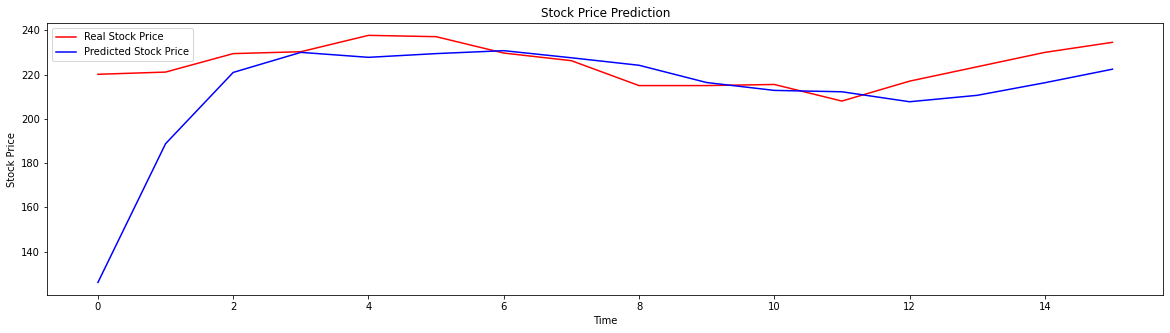

In [50]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(predicted_stock_price, real_stock_price))
mse = mean_squared_error(predicted_stock_price, real_stock_price)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  13.795685386657714
Mean Squared Error:  676.9238381253012
Root Mean Squared Error:  26.017760052035634


In [52]:
predicted_stock_price = predicted_stock_price.reshape(-1)
print(predicted_stock_price)
print()

real_stock_price = real_stock_price.reshape(-1)
print(real_stock_price)

[126.02443 188.72029 220.94383 230.01059 227.7667  229.45161 230.7789
 227.56952 224.17755 216.38014 212.82513 212.19891 207.69586 210.59325
 216.28607 222.4063 ]

[220.1  221.1  229.45 230.3  237.7  237.1  229.7  226.25 215.   215.
 215.5  208.   217.   223.5  230.   234.55]


In [53]:
print(np.c_[real_stock_price, predicted_stock_price])

[[220.1        126.02442932]
 [221.1        188.72029114]
 [229.45       220.9438324 ]
 [230.3        230.0105896 ]
 [237.7        227.76669312]
 [237.1        229.45161438]
 [229.7        230.77890015]
 [226.25       227.56951904]
 [215.         224.17755127]
 [215.         216.38014221]
 [215.5        212.82513428]
 [208.         212.19891357]
 [217.         207.69586182]
 [223.5        210.59324646]
 [230.         216.28607178]
 [234.55       222.40629578]]
